In [1]:
# %load_ext rpy2.ipython
# %load_ext RWinOut # hack to see the output, https://github.com/vitorcurtis/RWinOut

In [2]:
from tqdm import tqdm_notebook

import pandas as pd
pd.set_option('display.max_columns', 500)

from standardiser import standardise
import molvs

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem.Descriptors as D
# from rdkit.Chem.Descriptors import MolWt

[08/06/19 12:54:19 standardiser.standardise WARNING] Running under Windows: must disable use of timeout


# Data preparation

In [2]:
receptors = 'ERa,ERb,GR,MR,PR,AR'.split(',')
receptors_chembl_ids = 'CHEMBL206,CHEMBL242,CHEMBL2034,CHEMBL1994,CHEMBL208,CHEMBL1871'.split(',')
chembl_id_to_name = {a:b for a,b in zip(receptors_chembl_ids, receptors)}

In [3]:
df_union = pd.DataFrame()
for receptor in receptors:
    df = pd.read_csv('primary_data/CHEMBL25-{}.csv'.format(receptor))
    df_union = pd.concat([df_union, df])
    del df
df_union.rename(lambda x:x.replace(' ','_'), axis='columns', inplace=True)

In [4]:
df_clean = df_union.query('Standard_Units == "nM" and Standard_Relation == "=" and not Canonical_Smiles.isnull()')
df_clean["receptor_name"] = df_clean.Target.apply(lambda x:chembl_id_to_name[x])

f:\programy\Miniconda3\envs\main\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
df_molecules = df_clean[["Molecule", "Canonical_Smiles"]] \
    .drop_duplicates() \
    .set_index('Molecule')

In [10]:
# standardise molecules and group activities by the standardised parent molecule
class CustomStandardiser:
    def __init__(self):
        self.standardiser = molvs.Standardizer()
        self.tautomer_canonicalizer = molvs.tautomer.TautomerCanonicalizer()
        self.reionzer = molvs.charge.Reionizer()

    def standardise(self, smiles):
        mol = MolFromSmiles(smiles)
        try:
            standard_parent = standardise.run(mol) # Francis Atkinson
            standard_parent2 = self.standardiser.standardize(standard_parent) # MolVS
            tautomer_parent = self.tautomer_canonicalizer.canonicalize(standard_parent2) # MolVS tautomer
            reionized_parent = self.reionzer.reionize(tautomer_parent) # MolVS reionize
            
            return reionized_parent
        except Exception as e:
            print(e)
            display(mol)
            print('---')
            return None

In [11]:
cs = CustomStandardiser()

No non-salt/solvate components


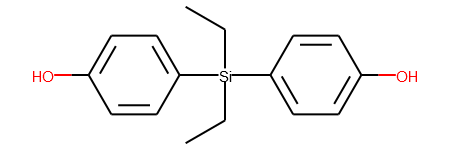

---
No non-salt/solvate components


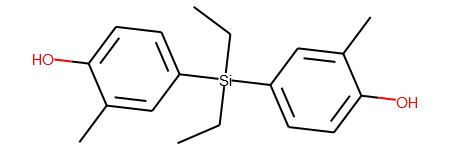

---
No non-salt/solvate components


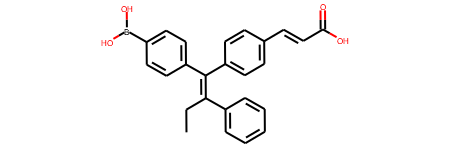

---
No non-salt/solvate components


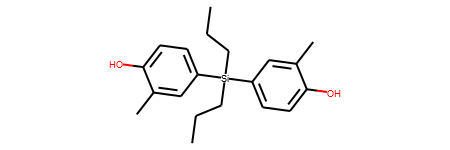

---
Multiple non-salt/solvate components


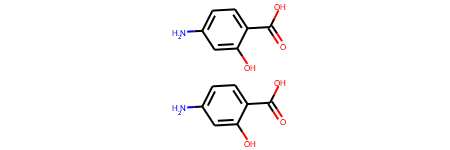

---
No non-salt/solvate components


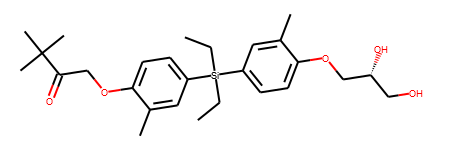

---
No non-salt/solvate components


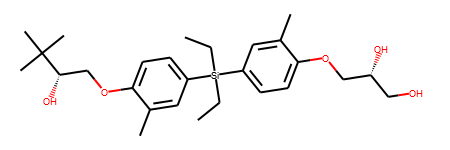

---
No non-salt/solvate components


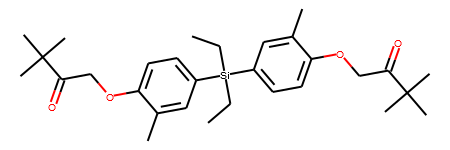

---
No non-salt/solvate components


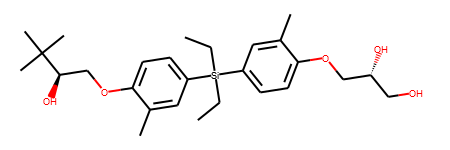

---
No non-salt/solvate components


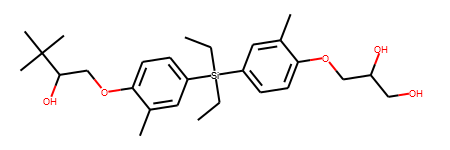

---
No non-salt/solvate components


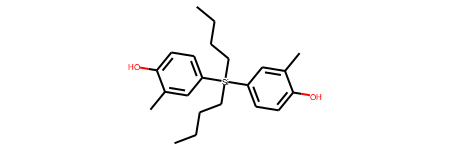

---
No non-salt/solvate components


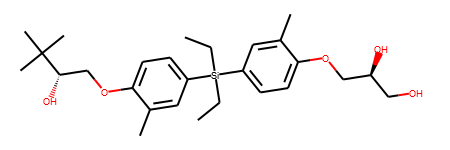

---
No non-salt/solvate components


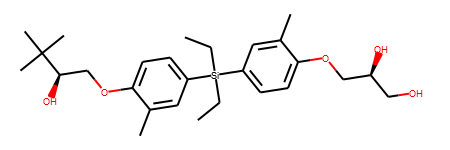

---


In [12]:
std_mols = np.asarray(list(map(cs.standardise, tqdm_notebook(df_molecules.Canonical_Smiles.values))))

In [6]:
np.save('secondary_data/std_mols.npy',std_mols)

NameError: name 'std_mols' is not defined

In [7]:
std_mols = np.load('secondary_data/std_mols.npy', allow_pickle=True)

In [8]:
df_molecules['std_smiles'] = [x if x is None else MolToSmiles(x) for x in std_mols]
df_molecules['std_inchi']  = [x if x is None else MolToInchi(x) for x in std_mols]
df_molecules['std_inchi_key'] = [x if x is None else InchiToInchiKey(x) for x in df_molecules.std_inchi]

In [10]:
df_molecules_std = df_molecules[std_mols != None] \
    .drop_duplicates('std_inchi_key') \
    .set_index('std_inchi_key') \
    .drop('Canonical_Smiles', axis='columns')

In [12]:
df_molecules.drop(['Canonical_Smiles','std_smiles','std_inchi'], axis='columns', inplace=True)

In [13]:
df_activity = df_clean \
    .join(df_molecules, on='Molecule', how='inner') \
    .join(df_molecules_std, on='std_inchi_key', how='inner') \
    .groupby(['std_inchi_key', 'receptor_name']) \
    .aggregate('median') \
    .Standard_Value \
    .to_frame() \
    .reset_index('receptor_name')

## Generate fingerprints and scaffolds

In [15]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [16]:
df_molecules_std['std_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in std_mols_clean]

In [17]:
scaffolds = [Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol) for mol in std_mols_clean]

In [267]:
df_molecules_std['scaffold_smiles'] = [MolToSmiles(mol) for mol in scaffolds]

In [19]:
df_molecules_std['scaffold_morgan_fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString() for mol in scaffolds]

In [268]:
df_clean.to_csv('secondary_data/df_clean.csv')
df_molecules_std.to_csv('secondary_data/df_molecules_std.csv')
df_activity.to_csv('secondary_data/df_activity.csv')